This notebook analyzes data from https://github.com/HuthLab/deep-fMRI-dataset. To set up, see instructions in the `deep-fMRI-dataset` folder.

In [10]:
%load_ext autoreload
%autoreload 2
import datasets
import numpy as np
from os.path import join
from ridge_utils.SemanticModel import SemanticModel
from matplotlib import pyplot as plt
from typing import List
from sklearn.linear_model import RidgeCV, LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer
from feature_spaces import em_data_dir, data_dir, results_dir
from collections import defaultdict
import pandas as pd
import os
import seaborn as sns
# from fit_linear_models import get_dsets
from ridge_utils.SemanticModel import SemanticModel
import encoding_utils, feature_spaces
from transformers.pipelines.pt_utils import KeyDataset
from feature_spaces import *
from transformers import pipeline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load fMRI prediction results

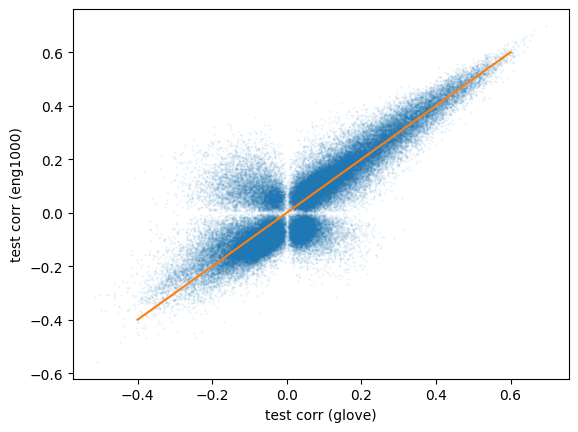

In [2]:
corrs_glove = np.load(join(results_dir, 'glove', 'UTS03', 'corrs.npz'))['arr_0']
corrs_eng1000 = np.load(join(results_dir, 'eng1000', 'UTS03', 'corrs.npz'))['arr_0']

plt.plot(corrs_glove, corrs_eng1000, '.', alpha=0.1, ms=1)
plt.plot([-.4, .6], [-.4, .6])
plt.xlabel('test corr (glove)')
plt.ylabel('test corr (eng1000)')
plt.show()

In [ ]:
# compare two subjects
corrs_glove_01 = np.load(join(results_dir, 'glove', 'UTS01', 'corrs.npz'))['arr_0']
print('01', np.mean(corrs_glove_01), '03', np.mean(corrs_glove))

In [11]:
import datasets

Dataset({
    features: ['text'],
    num_rows: 3
})

# Load linear modeling results

In [7]:
save_dir = '/home/chansingh/mntv1/deep-fMRI/results/linear_models/oct10'
dfs = []
fnames = os.listdir(save_dir)[::-1]
for fname in fnames:
    df = pd.read_pickle(join(save_dir, fname))
    # print(fname)
    # display(df)
    dfs.append(df.reset_index())
d = pd.concat(dfs).drop(columns='coef_').round(2)
# d.set_index(['feats', 'dset'], inplace=True)
d

In [ ]:
sns.barplot(data=d, x='dset', y='acc', hue='feats')
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)

# Load dataset

In [13]:
dataset = 'trec'
X, y, X_test, y_test = get_dsets(dataset)
print('shapes', len(X), len(X_test))
print('labels', np.unique(y), np.unique(y_test))

Using custom data configuration default
Reusing dataset trec (/home/chansingh/.cache/huggingface/datasets/trec/default/1.1.0/751da1ab101b8d297a3d6e9c79ee9b0173ff94c4497b75677b59b61d5467a9b9)


  0%|          | 0/2 [00:00<?, ?it/s]

Using custom data configuration default
Reusing dataset trec (/home/chansingh/.cache/huggingface/datasets/trec/default/1.1.0/751da1ab101b8d297a3d6e9c79ee9b0173ff94c4497b75677b59b61d5467a9b9)


  0%|          | 0/2 [00:00<?, ?it/s]

shapes 5452 500
labels [0 1 2 3 4 5] [0 1 2 3 4 5]


# Test models

In [15]:
# glove = SemanticModel.load_np(join(nlp_utils_dir, 'glove'))
wordseqs = get_story_wordseqs(['sloth'])
# vectors = {}
# for story in allstories:
	# sm = apply_model_to_words(wordseqs[story], glove, 300)
	# vectors[story] = sm.data
# return downsample_word_vectors(allstories, vectors, wordseqs)

In [16]:
ds = wordseqs['sloth']

In [17]:
pipe = pipeline("feature-extraction", model="bert-base-uncased", device=0)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
ngram_size = 9
ngrams_list = []
for i in range(100):
    l = max(0, i + 1 - ngram_size)
    ngram = ' '.join(ds.data[l: i])
    ngrams_list.append(ngram)

In [ ]:
datasets.Dataset.from_dict({'text': ['fadsfa', 'vcs', 'fdsafd']})

In [12]:


print(ngrams_list[:10])
# embeddings are (batch_size, 1, (seq_len + 2), 768) -- BERT adds initial / final tokens
out_list = pipe(ngrams_list)

# convert to np array by averaging over len (can't just convert this since seq lens vary)
# embs = np.array(out).squeeze().mean(axis=1)
num_ngrams = len(out_list)
dim_size = len(out_list[0][0][0])
embs = np.zeros((num_ngrams, dim_size))
for i in range(len(out_list)):
    embs[i] = np.mean(out_list[i], axis=1) # avg over seq_len dim

['', 'so', "so i'm", "so i'm sitting", "so i'm sitting in", "so i'm sitting in my", "so i'm sitting in my shrink's", "so i'm sitting in my shrink's office", "so i'm sitting in my shrink's office this", "i'm sitting in my shrink's office this one"]
(100, 768)


In [86]:
len(out_list), len(out_list[0]), len(out_list[0][0]), len(out_list[0][0][0])

(100, 1, 2, 768)

In [23]:
# ds.split_inds
print('data_times', ds.data_times[:50])
print('tr_times', ds.tr_times[:50])

data_times [ 1.56394558  2.19750567  2.88594104  3.53945578  4.38253968  4.97120181
  5.80430839  6.40294785  6.62244898  6.90181406  8.43333333  8.85736961
  9.10181406  9.31632653  9.63955874 10.98253968 11.18208617 11.47142857
 12.2446712  12.37936508 12.69863946 13.21746032 13.55170068 13.70634921
 13.98072562 14.36485261 15.5521542  15.69183673 15.79160998 16.14580499
 16.91405896 17.68730159 18.56530612 19.79251701 19.94217687 20.2582746
 21.47530348 21.52364108 21.6789174  21.94761905 22.14716553 22.38662132
 22.64603175 22.79070295 22.88049887 23.03015873 23.30952381 23.52902494
 23.68866213 23.99297052]
tr_times [-9. -7. -5. -3. -1.  1.  3.  5.  7.  9. 11. 13. 15. 17. 19. 21. 23. 25.
 27. 29. 31. 33. 35. 37. 39. 41. 43. 45. 47. 49. 51. 53. 55. 57. 59. 61.
 63. 65. 67. 69. 71. 73. 75. 77. 79. 81. 83. 85. 87. 89.]


In [24]:
ds.chunks()[:10]

[array([], dtype='<U16'),
 array([], dtype='<U16'),
 array([], dtype='<U16'),
 array([], dtype='<U16'),
 array([], dtype='<U16'),
 array(['so', "i'm"], dtype='<U16'),
 array(['sitting', 'in'], dtype='<U16'),
 array(['my', "shrink's", 'office'], dtype='<U16'),
 array(['this', 'one', 'time'], dtype='<U16'),
 array(['and', 'he', 'says', 'to', 'me'], dtype='<U16')]

In [14]:
newdata = []
num_lsasms = len(lsasms)
for w in ds.data:
    v = []
    for i in range(num_lsasms):
        lsasm = lsasms[i]
        size = sizes[i]
        try:
            v = np.concatenate((v, lsasm[str.encode(w.lower())]))
        except KeyError as e:
            v = np.concatenate((v, np.zeros((size)))) #lsasm.data.shape[0],))
    newdata.append(v)

[autoreload of ridge_utils.dsutils failed: Traceback (most recent call last):
  File "/home/chansingh/.embgam/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/chansingh/.embgam/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/usr/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 848, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/chansingh/emb-gam/experimental/fmri/encoding/ridge_utils/dsutils.py", line 4, in <module>
    from transformers import pipe
ImportError: cannot import name 'pipe' from 'transformers' (/home/chansingh/.embgam/lib/python3.8/site-packages/transformers/__init__.py)
]


NameError: name 'lsasms' is not defined